In [1]:
import torch
import torchvision

In [2]:
print(torch.__version__)
print(torchvision.__version__)

1.4.0
0.5.0


In [3]:
model = torch.hub.load('pytorch/vision:v0.5.0', 'resnet18', pretrained=True)

Using cache found in /home/bohumil/.cache/torch/hub/pytorch_vision_v0.5.0


In [4]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [5]:
# from torchvision import transforms
# preprocess = transforms.Compose([
#     transforms.Resize(256),
#     transforms.CenterCrop(224),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
# ])
# # dataset = torchvision.datasets.ImageNet('/home/bohumil/FIIT/BP/BP/Zdroje_kod/imagenet/train/', split='train', transform=preprocess)
# dataset = torchvision.datasets.ImageNet('/home/bohumil/FIIT/BP/BP/Zdroje_kod/tiny-imagenet-200', split='train', transform=preprocess)
# 
# dataset, _ = torch.utils.data.random_split(dataset, [500, dataset.samples-500])
# 
# batch_size = 30
# num_workers = 1
# 
# dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, num_workers= num_workers)
# 

In [6]:
# import distiller.apputils.data_loaders as data
# 
# batch_size = 30
# num_workers = 1
# train_loader, val_loader, test_loader, _ = data.load_data('imagenet','/home/bohumil/FIIT/BP/BP/Zdroje_kod/tiny-imagenet-200',
#                                                           batch_size=batch_size, 
#                                                           workers=num_workers,validation_split=0.05)

In [20]:
from torchvision import transforms
# from torch.utils.data import DataLoader

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
preprocessing = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    normalize,
])

batch_size = 40
num_workers = 1
dataset = torchvision.datasets.ImageFolder('/home/bohumil/FIIT/BP/BP/Zdroje_kod/imagenet/train'
                                           ,preprocessing)

small, big = torch.utils.data.random_split(dataset,[7000, len(dataset)-7000])
 
dataloader = torch.utils.data.DataLoader(dataset,batch_size=batch_size,
                                         num_workers=num_workers,shuffle=True)



In [21]:
# data1,data2 = torch.utils.data.random_split(dataset,[500, len(dataset)-500])

In [24]:
from resnet_output import resnet_output

def target_labels(dataset,target):
    list = target.tolist()
    for i in range(len(list)):
        list[i] = dataset.classes[list[i]]
        list[i] = resnet_output[list[i]]
    return torch.LongTensor(list)

In [22]:
import torchnet as tnt
import math
import numpy as np
from resnet_output import resnet_output


def eval_model(data_loader, model, device='cpu', print_freq=10 , max_steps=20):
    # print('Evaluation model ', model.arch)
    
    criterion = torch.nn.CrossEntropyLoss().to(device)
    
    loss = tnt.meter.AverageValueMeter()
    classerr = tnt.meter.ClassErrorMeter(accuracy=True, topk=(1, 5))

    total_samples = len(data_loader.sampler)
    batch_size = data_loader.batch_size
    total_steps = math.ceil(total_samples / batch_size)
    print('{0} samples ({1} per mini-batch)'.format(total_samples, batch_size))

    # Switch to evaluation mode
    model.eval()

    for step, (inputs, target) in enumerate(data_loader):
        with torch.no_grad():
            inputs, target = inputs.to(device), target.to(device)
            # compute output from model
            output = model(inputs)
           
            target = target_labels(dataset,target).to(device)
            # compute loss and measure accuracy
            loss.add(criterion(output, target).item())
            classerr.add(output, target)
            
            if (step + 1) % print_freq == 0:
                print('[{:3d}/{:3d}] Top1: {:.3f}  Top5: {:.3f}  Loss: {:.3f}'.format(
                      step + 1, total_steps, classerr.value(1), classerr.value(5), loss.mean), flush=True)
            if max_steps<= step:
                break
    print('----------')
    print('Overall ==> Top1: {:.3f}  Top5: {:.3f}  Loss: {:.3f} PPL: {:.3f}'.format(
        classerr.value(1), classerr.value(5), loss.mean, np.exp(loss.mean)), flush=True)
eval_model(dataloader,model.to('cuda'),'cuda',print_freq=30, max_steps=1000)    

19439 samples (40 per mini-batch)
[ 30/486] Top1: 79.333  Top5: 94.667  Loss: 0.773
[ 60/486] Top1: 79.667  Top5: 94.667  Loss: 0.753
[ 90/486] Top1: 79.417  Top5: 94.389  Loss: 0.779
[120/486] Top1: 79.083  Top5: 94.375  Loss: 0.786
[150/486] Top1: 78.917  Top5: 94.333  Loss: 0.796
[180/486] Top1: 79.111  Top5: 94.458  Loss: 0.789
[210/486] Top1: 79.250  Top5: 94.417  Loss: 0.789
[240/486] Top1: 79.385  Top5: 94.521  Loss: 0.788
[270/486] Top1: 79.139  Top5: 94.352  Loss: 0.799
[300/486] Top1: 79.158  Top5: 94.367  Loss: 0.797
[330/486] Top1: 79.008  Top5: 94.295  Loss: 0.801
[360/486] Top1: 79.160  Top5: 94.319  Loss: 0.796
[390/486] Top1: 78.994  Top5: 94.263  Loss: 0.802
[420/486] Top1: 78.720  Top5: 94.226  Loss: 0.808
[450/486] Top1: 78.828  Top5: 94.261  Loss: 0.803
[480/486] Top1: 78.719  Top5: 94.193  Loss: 0.806
----------
Overall ==> Top1: 78.723  Top5: 94.197  Loss: 0.806 PPL: 2.239


In [32]:
resnet_output

19439 samples (1 per mini-batch)
[ 30/19439] Top1: 93.333  Top5: 96.667  Loss: 0.199
[ 60/19439] Top1: 85.000  Top5: 96.667  Loss: 0.664
[ 90/19439] Top1: 58.889  Top5: 95.556  Loss: 1.555
[120/19439] Top1: 44.167  Top5: 85.000  Loss: 2.546
[150/19439] Top1: 35.333  Top5: 69.333  Loss: 4.900
[180/19439] Top1: 29.444  Top5: 57.778  Loss: 7.015
[210/19439] Top1: 25.238  Top5: 49.524  Loss: 8.358
[240/19439] Top1: 22.083  Top5: 43.333  Loss: 9.473
[270/19439] Top1: 19.630  Top5: 42.963  Loss: 9.571
[300/19439] Top1: 17.667  Top5: 40.000  Loss: 9.912
----------
Overall ==> Top1: 17.608  Top5: 39.867  Loss: 9.929 PPL: 20516.588


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fb2d67cce60>
Traceback (most recent call last):
  File "/home/bohumil/FIIT/BP/BP/Zdroje_kod/dist_env/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 961, in __del__
    self._shutdown_workers()
  File "/home/bohumil/FIIT/BP/BP/Zdroje_kod/dist_env/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 941, in _shutdown_workers
    w.join()
  File "/usr/lib/python3.7/multiprocessing/process.py", line 138, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process


In [ ]:
eval_model(dataloader,model.to('cuda'),'cuda',print_freq=30, max_steps=300)

In [27]:
from copy import deepcopy
from resnet_output import resnet_output

model.eval()
it = iter(dataloader)
inputs, target = next(it)
target_copy = deepcopy(target)
model.to('cuda')
classerr = tnt.meter.ClassErrorMeter(accuracy=True, topk=(1, 5))

# for i in range(5):
inputs, target = next(it)
with torch.no_grad():
        inputs, target = inputs.to('cuda'), target.to('cuda')
        # compute output from model
        output = model(inputs)
        classerr.add(output, target)
        print('Top1-Acc {} Top5-Acc {}'.format(classerr.value(1), classerr.value(5)))
        
output

Top1-Acc 0.0 Top5-Acc 0.0


tensor([[-4.5842e+00, -2.3985e+00, -3.3450e+00, -5.6480e+00, -2.5133e+00,
         -4.2481e+00, -3.3082e+00,  4.0641e-01,  1.2471e-01, -3.6378e+00,
         -1.3684e+00,  1.7891e-01, -1.3314e+00, -1.7268e+00, -2.8343e+00,
         -1.3018e+00,  1.6668e+00, -1.9638e+00, -5.0561e-01,  7.2624e-02,
         -2.9143e+00, -1.4867e+00, -6.0885e-01, -1.1673e+00, -3.4213e+00,
          1.0523e+00, -1.0522e+00, -4.5244e-01,  6.0226e-01, -3.4903e+00,
         -9.2159e-01, -5.2509e-01, -1.6108e+00, -2.7350e+00, -4.3273e+00,
         -1.7142e+00,  5.8224e-01,  5.0186e-01, -1.1463e+00,  1.4119e+00,
         -7.4603e-03, -1.6302e+00, -9.6837e-01, -9.4190e-01, -7.2328e-02,
          9.1536e-01,  1.2071e-01, -4.1582e-02, -2.4519e+00, -3.3043e-01,
         -1.1315e+00, -7.9246e-01, -9.9173e-01,  1.5823e+00, -2.1295e-01,
         -4.8392e-01,  8.6798e-01, -7.3140e-01, -2.4332e+00, -1.9822e-01,
          5.1447e-01,  1.6185e+00, -3.8470e-01, -1.3381e+00, -5.0998e-01,
         -6.8487e-01, -2.4183e-01,  5.

In [28]:
output.shape

torch.Size([1, 1000])

In [29]:
soft = torch.nn.functional.softmax(output[0], dim= 0)

top = torch.topk(soft, 5)

In [30]:
top

torch.return_types.topk(
values=tensor([0.8773, 0.0289, 0.0179, 0.0173, 0.0073], device='cuda:0'),
indices=tensor([907, 720, 440, 966, 558], device='cuda:0'))

In [31]:
classer = tnt.meter.ClassErrorMeter(accuracy=True, topk=(1, 5))
classer.add(output[0],target[0])
print(classer.value(1),classer.value(5))

0.0 0.0


In [32]:
from imagenet_classes import imagenet_classes

vals = top.values.tolist()
ind = top.indices.tolist()
targ = target.tolist()[0]
for i in range(len(vals)):
    print("{:3f} for {} is {}".format(vals[i]*100, ind[i], imagenet_classes[ind[i]]))
    
print("Where truth is {} named: {}".format(targ, imagenet_classes[targ]))    
print("in dataset {}".format(dataset.classes[targ]))


print("in class_to_idx {}".format(dataset.class_to_idx[dataset.classes[targ]]))
print("in targets {}".format(dataset.targets[targ]))
print(list(dataset.class_to_idx.keys()).index(dataset.classes[targ]))

87.726086 for 907 is wine bottle
2.894725 for 720 is pill bottle
1.792141 for 440 is beer bottle
1.730794 for 966 is red wine
0.727025 for 558 is flute, transverse flute
Where truth is 691 named: oxygen mask
in dataset n04591713
in class_to_idx 691
in targets 27
691


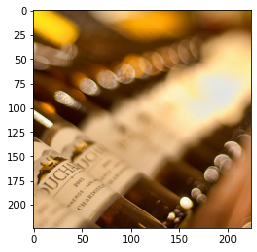

In [33]:
import matplotlib.pyplot as plt
import kornia

norm = kornia.denormalize(inputs[0].cpu(), mean=torch.FloatTensor([0.485, 0.456, 0.406]),
                                 std=torch.FloatTensor([0.229, 0.224, 0.225]))
conv = torchvision.transforms.ToPILImage(mode='RGB')
plt.imshow(conv(norm.squeeze()))
plt.savefig('out.png')
plt.show()

In [ ]:
print(dataset.classes[4])

In [ ]:
# print(dataset.imgs.index('/home/bohumil/FIIT/BP/BP/Zdroje_kod/imagenet/train/n01440764/n01494475_6702.JPEG'))

[item for item in dataset.imgs if '/home/bohumil/FIIT/BP/BP/Zdroje_kod/imagenet/train/n02666196/n02666196_17054.JPEG' in item]

In [13]:
old = dict(enumerate(dataset.classes)) 
  
new_class_to_idx = dict([(value, key) for key, value in old.items()]) 

In [15]:
new_class_to_idx

dataset.class_to_idx = new_class_to_idx

In [ ]:
torch.save(model.state_dict(), '.chckpt/resnet18_hub.st')

In [34]:
from torchvision import transforms
# from torch.utils.data import DataLoader

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
preprocessing = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    normalize,
])

batch_size = 1
num_workers = 1
dataset2 = torchvision.datasets.ImageFolder('/home/bohumil/FIIT/BP/BP/Zdroje_kod/imagenet_deb/train'
                                           ,preprocessing)
 
dataloader2 = torch.utils.data.DataLoader(dataset2,batch_size=batch_size,
                                         num_workers=num_workers,shuffle=True)

In [35]:
from copy import deepcopy
model.eval()
it2 = iter(dataloader2)
inputs2, target2 = next(it)
target_copy2 = deepcopy(target2)
model.to('cuda')
classerr = tnt.meter.ClassErrorMeter(accuracy=True, topk=(1, 5))

# for i in range(5):
inputs2, target2 = next(it2)
with torch.no_grad():
        inputs2, target2 = inputs2.to('cuda'), target2.to('cuda')
        # compute output from model
        output2 = model(inputs2)
        classerr.add(output2, target2)
        print('Top1-Acc {} Top5-Acc {}'.format(classerr.value(1), classerr.value(5)))
        
output2

Top1-Acc 0.0 Top5-Acc 0.0


tensor([[-4.5842e+00, -2.3985e+00, -3.3450e+00, -5.6480e+00, -2.5133e+00,
         -4.2481e+00, -3.3082e+00,  4.0641e-01,  1.2471e-01, -3.6378e+00,
         -1.3684e+00,  1.7891e-01, -1.3314e+00, -1.7268e+00, -2.8343e+00,
         -1.3018e+00,  1.6668e+00, -1.9638e+00, -5.0561e-01,  7.2624e-02,
         -2.9143e+00, -1.4867e+00, -6.0885e-01, -1.1673e+00, -3.4213e+00,
          1.0523e+00, -1.0522e+00, -4.5244e-01,  6.0226e-01, -3.4903e+00,
         -9.2159e-01, -5.2509e-01, -1.6108e+00, -2.7350e+00, -4.3273e+00,
         -1.7142e+00,  5.8224e-01,  5.0186e-01, -1.1463e+00,  1.4119e+00,
         -7.4603e-03, -1.6302e+00, -9.6837e-01, -9.4190e-01, -7.2328e-02,
          9.1536e-01,  1.2071e-01, -4.1582e-02, -2.4519e+00, -3.3043e-01,
         -1.1315e+00, -7.9246e-01, -9.9173e-01,  1.5823e+00, -2.1295e-01,
         -4.8392e-01,  8.6798e-01, -7.3140e-01, -2.4332e+00, -1.9822e-01,
          5.1447e-01,  1.6185e+00, -3.8470e-01, -1.3381e+00, -5.0998e-01,
         -6.8487e-01, -2.4183e-01,  5.

In [36]:
output2.shape

torch.Size([1, 1000])

In [37]:
soft2 = torch.nn.functional.softmax(output2[0], dim= 0)

top2 = torch.topk(soft2, 5)

In [38]:
top2

torch.return_types.topk(
values=tensor([0.8773, 0.0289, 0.0179, 0.0173, 0.0073], device='cuda:0'),
indices=tensor([907, 720, 440, 966, 558], device='cuda:0'))

In [39]:
classer2 = tnt.meter.ClassErrorMeter(accuracy=True, topk=(1, 5))
classer2.add(output2[0],target2[0])
print(classer2.value(1),classer2.value(5))

0.0 0.0


In [40]:
from imagenet_classes import imagenet_classes

vals2 = top2.values.tolist()
ind2 = top2.indices.tolist()
targ2 = target2.tolist()[0]
for i in range(len(vals2)):
    print("{:3f} for {} is {}".format(vals2[i]*100, ind2[i], imagenet_classes[ind2[i]]))
    
print("Where truth is {} named: {}".format(targ2, imagenet_classes[targ2]))    
print("in dataset {}".format(dataset2.classes[targ2]))


print("in class_to_idx {}".format(dataset2.class_to_idx[dataset2.classes[targ2]]))
print("in targets {}".format(dataset2.targets[targ2]))
print(list(dataset2.class_to_idx.keys()).index(dataset2.classes[targ]))

87.726086 for 907 is wine bottle
2.894725 for 720 is pill bottle
1.792141 for 440 is beer bottle
1.730794 for 966 is red wine
0.727025 for 558 is flute, transverse flute
Where truth is 0 named: tench, Tinca tinca
in dataset n04591713
in class_to_idx 0
in targets 0


IndexError: list index out of range

In [ ]:
import matplotlib.pyplot as plt
import kornia

norm2 = kornia.denormalize(inputs2[0].cpu(), mean=torch.FloatTensor([0.485, 0.456, 0.406]),
                                 std=torch.FloatTensor([0.229, 0.224, 0.225]))
conv2 = torchvision.transforms.ToPILImage(mode='RGB')
plt.imshow(conv2(norm2.squeeze()))
plt.savefig('out2.png')
plt.show()



